# File Upload

In [1]:
from google.colab import files


# csv file
uploaded = files.upload()
for f in uploaded.keys():
    print('User iploaded file "{name}" with length {length} bytes\n'.format(name = f, length = len(uploaded[f])))

Saving hw3_data.csv to hw3_data.csv
User iploaded file "hw3_data.csv" with length 131370 bytes



# Task 

## Model: $y = f(x)$
## Approach: Multi-Layer-Perceptron (MLP) Regressor

## 1. Read the .csv file and store the data into the dataframe 

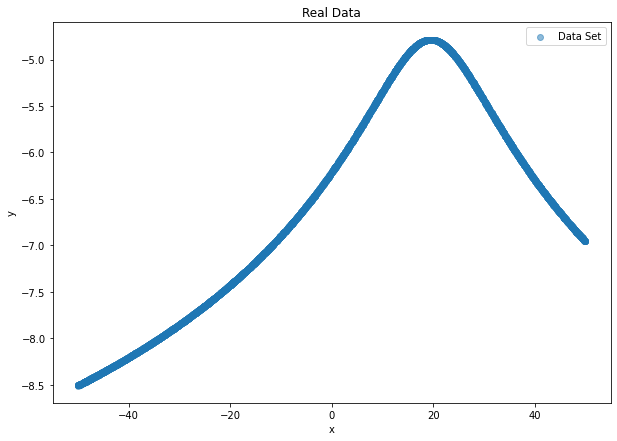

In [418]:
import pandas as pd
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 7))
plt.title("Real Data")

data = pd.read_csv("./hw3_data.csv").sort_values(by='x', axis=0)
plt.scatter(data['x'], data['y'], color='tab:blue', alpha=0.5, label="Data Set")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## 2. Define the perceptron used in the multi-layer perceptron (MLP)

### 2.1 Define Activation Functions

In [419]:
import numpy as np


# Sigmoid
class Sigmoid:
    def forward(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def derivate(self, x):
        return (1 - self.forward(x)) * self.forward(x)


# Relu
class Relu:
    def forward(self, x):
        return np.where(x > 0, x, 0.0)

    def derivate(self, x):
        return np.where(x > 0, 1.0, 0.0)


# Hyperbolic Tangent
class Tanh:
    def forward(self, x):
        return np.tanh(x)

    def derivate(self, x):
        return 1 - np.tanh(x) ** 2


# Identity
class Identity:
    def forward(self, x):
        return x

    def derivate(self, x):
        return 1

### 2.2 Define Initializer

In [420]:
import numpy as np


# Randomly generates the weights and bias
class Rand:
    def initialize(self, layer):
        w = np.random.randn(layer.input_dim, layer.output_dim)
        b = np.random.randn(1, layer.output_dim)
        dw = np.zeros([layer.input_dim, layer.output_dim])
        db = np.zeros([1, layer.output_dim])
        return w, b, dw, db

### 2.3 Define Layer

In [421]:
import numpy as np


# Dense layer
class Dense:
    def __init__(self, units= None, activation=None, input_dim=None, initializer=Rand(), initialize=False):
        self.w = None   # weight
        self.b = None   # bias
        self.z = None   # input
        self.a = None   # output
        self.d = None   # derivative
        self.dw = None  # derivative of weight
        self.db = None  # derivative of bias

        self.output_dim = units         # number of output
        self.input_dim = input_dim      # number of input
        self.activation = activation    # activation function
        self.initializer = initializer  # initializer of the layer

        if initialize:
            self.reset_layer()


    # Initialize the weights and bias of layer
    def reset_layer(self):
        w, b, dw, db = self.initializer.initialize(self)
        self.w = w
        self.b = b
        self.dw = dw
        self.db = db


    # Forward operation
    def forward(self, x, update=True):
        z = np.matmul(x, self.w) + self.b
        a = self.activation.forward(z)
        if update:
            self.z = z
            self.a = a
        return a


    # Update the derivative of weight and bias for the layer
    def update_delta(self, next_layer):
        d = np.matmul(next_layer.d, next_layer.w.T) * self.activation.derivate(self.z)
        self.d = d


    #  Update the weight and bias for the layer
    def update_gradients(self, a_in):
        d_out = self.d
        self.db = d_out.sum(axis=0).reshape([1, -1])
        self.dw = np.matmul(a_in.T, d_out)

### 2.4 Define Loss

In [422]:
import numpy as np


# Loss function -> mean squared error (MSE)
class MSE:
    def forward(self, actual, prediction):
        return 0.5 * ((prediction - actual) ** 2)

    def derivate(self, actual, prediction):
        return prediction - actual

### 2.5 Define Optimizer

In [423]:
import numpy as np


# General optimizer for gradient descent algorithm
class GradientDescent:
    def __init__(self, learning_rate=0.001):
        self.learning_rate = learning_rate

    # Initialize the parameters
    def initialize_parameters(self, layers):
        return layers

    # Update weights of the layer
    def update_weights(self, layers):
        for i in range(len(layers)):
            layers[i].w = layers[i].w - self.learning_rate * layers[i].dw
            layers[i].b = layers[i].b - self.learning_rate * layers[i].db
        return layers


# Adam optimizer -> used to optimize the layer with random weight and bias
class Adam:
    def __init__(self, learning_rate=0.001):
        self.t = 1
        self.b1 = 0.9
        self.b2 = 0.999
        self.epsilon = 1e-8
        self.learning_rate = learning_rate

    # Initialize the parameters in the Adam optimizer
    def initialize_parameters(self, layers):
        for i, layer in enumerate(layers):
            adam = {
                "mw": np.zeros([layer.input_dim, layer.output_dim]),
                "mb": np.zeros([1, layer.output_dim]),
                "vw": np.zeros([layer.input_dim, layer.output_dim]),
                "vb": np.zeros([1, layer.output_dim]),
            }
            layers[i].adam = adam

        return layers


    # Update the weight of the layer with the Adam parameters
    def update_weights(self, layers):
        t = self.t
        for i, layer in enumerate(layers):
            adam = {
                "mw": (self.b1 * layer.adam["mw"] + (1 - self.b1) * layer.dw),
                "mb": (self.b1 * layer.adam["mb"] + (1 - self.b1) * layer.db),
                "vw": (self.b2 * layer.adam["vw"] + (1 - self.b2) * layer.dw ** 2),
                "vb": (self.b2 * layer.adam["vb"] + (1 - self.b2) * layer.db ** 2)
            }

            layer.adam = adam
            mw_corrected = adam["mw"] / (1 - (self.b1 ** t))
            mb_corrected = adam["mb"] / (1 - (self.b1 ** t))
            vw_corrected = adam["vw"] / (1 - (self.b2 ** t))
            vb_corrected = adam["vb"] / (1 - (self.b2 ** t))

            layer.w = layer.w - (self.learning_rate * mw_corrected / (np.sqrt(vw_corrected) + self.epsilon))
            layer.b = layer.b - (self.learning_rate * mb_corrected / (np.sqrt(vb_corrected) + self.epsilon))
            layers[i] = layer

        self.t = t + 1
        return layers

### 2.6 Define Model

In [424]:
import numpy as np


# Multi-layer perceptron model
class MLPRegressor:
    def __init__(self):
        self.layers = []        # List of layers
        self.n_layers = 0       # Number of layers
        self.trainer = None     # Trainer
        self.train_log = None   # Log generated from the trainer


    # Add the layer to the MLP model
    def add(self, layer):
        if len(self.layers) > 0:
            layer.input_dim = self.layers[-1].output_dim
        
        layer.reset_layer()
        self.layers.append(layer)
        self.n_layers += 1

    # Predict output from the input
    def predict(self, x):
        pred = self.forward_prop(x, update=False)
        return pred


    # Train the MLP model
    def train(self, loss, train_data, optimizer=Adam(), params=None):
        self.trainer = ModelTrain()
        self.trainer.train(self, loss, train_data, optimizer, params)


    # Forward propagation
    def forward_prop(self, x, update=True):
        a = x
        for layer in self.layers:
            a = layer.forward(a, update=update)
        return a


    # Back propagation
    def back_prop(self, x, y, loss):
        self.update_deltas(loss, y)
        self.update_gradients(x)


    # Update the derivatives of weight and bias in the layers
    def update_deltas(self, loss, y):
        for i, layer in enumerate(reversed(self.layers)):
            if i == 0:
                d = loss.derivate(y, layer.a) * layer.activation.derivate(layer.z)
                layer.d = d
            else:
                layer_next = self.layers[-i]
                layer.update_delta(layer_next)


    # Update the weight and bias in the layers
    def update_gradients(self, x):
        for i, layer in enumerate(self.layers):
            if i == 0:
                a_in = x
            else:
                prev_layer = self.layers[i - 1]
                a_in = prev_layer.a
            layer.update_gradients(a_in)
            

    def reset_layers(self):
        for layer in self.layers:
            layer.reset_layer()

### 2.7 Define Batcher

In [425]:
import numpy as np


# Batcher that generates the batch for the training
class Batcher:
    def __init__(self, data, batch_size, shuffle_on_reset= False):
        self.data = data
        self.batch_size = batch_size
        self.shuffle_on_reset = shuffle_on_reset

        if type(data) == list:
            self.data_size = data[0].shape[0]
        else:
            self.data_size = data.shape[0]

        self.n_batches = int(np.ceil(self.data_size / self.batch_size))
        self.idx = np.arange(0, self.data_size, dtype=int)
        if shuffle_on_reset:
            np.random.shuffle(self.idx)
        self.current = 0


    # Shuffle the index
    def shuffle(self):
        np.random.shuffle(self.idx)


    # Reset the batcher
    def reset(self):
        if self.shuffle_on_reset:
            self.shuffle()
        self.current = 0


    # Select the next batch for the training
    def next(self):
        batch = []
        i_select = self.idx[(self.current * self.batch_size) : ((self.current + 1) * self.batch_size)]
        for elem in self.data:
            batch.append(elem[i_select])

        if self.current < (self.n_batches - 1):
            self.current = self.current + 1
        else:
            self.reset()

        return batch

### 2.8 Define Trainer

In [426]:
import numpy as np
import pandas as pd


# Trainer parameters
default_params = {
    "verbose": True,
    "n_epoch": 1000,
    "batch_size": 200,
    "print_rate": 100,
    "learning_rate": 0.5
}


# Model trainer
class ModelTrain:
    def __init__(self, params=None):
        self.batcher = None                 # Batcher
        self.optimizer = None               # Optimizer
        self.train_params = default_params  # Training parameters


    # Train the given model with the optimizer and batcher
    def train(self, model, loss, train_data, optimizer=Adam(), params=None):
        self.optimizer = optimizer
        model.layers = self.optimizer.initialize_parameters(model.layers)

        if self.batcher is None:
            self.batcher = Batcher(train_data, self.train_params["batch_size"])

        epoch = 1
        verbose = self.train_params["verbose"]

        train_loss = []
        model.train_log = []
        while epoch <= self.train_params["n_epoch"]:
            self.batcher.reset()

            for batch_i in range(self.batcher.n_batches):
                batch = self.batcher.next()
                x_batch = batch[0]
                y_batch = batch[1]

                self.train_step(model, x_batch, y_batch, loss)

                loss_i = self.compute_loss(model.layers[-1].a, y_batch, loss)
                train_loss.append(loss_i)
                model.train_log.append(np.array([epoch, batch_i, loss_i]))

            if verbose and (epoch % self.train_params["print_rate"] == 0):
                print(f"epoch: {epoch}\t|\ttrain_loss: {np.mean(train_loss)}")
            epoch += 1

        model.train_log = np.vstack(model.train_log)
        model.train_log = pd.DataFrame(model.train_log, columns=["epoch", "iter", "loss"])


    # Performs a single training step
    def train_step(self, model, x, y, loss):
        _ = model.forward_prop(x)
        model.back_prop(x, y, loss)
        model.layers = self.optimizer.update_weights(model.layers)


    # Compute the loss from the forward operation in current model
    def compute_loss(self, actual, prediction, loss):
        current_loss = loss.forward(actual, prediction)
        return current_loss.mean()

## 3. Main

epoch: 100	|	train_loss: 1.5738177779305682
epoch: 200	|	train_loss: 0.7944860294083158
epoch: 300	|	train_loss: 0.6655703378391047
epoch: 400	|	train_loss: 0.5631042684763372
epoch: 500	|	train_loss: 0.45152262511771396
epoch: 600	|	train_loss: 0.40108358593269045
epoch: 700	|	train_loss: 0.36162871614682396
epoch: 800	|	train_loss: 0.3388260598809411
epoch: 900	|	train_loss: 0.31817245911915826
epoch: 1000	|	train_loss: 0.29849529765472793


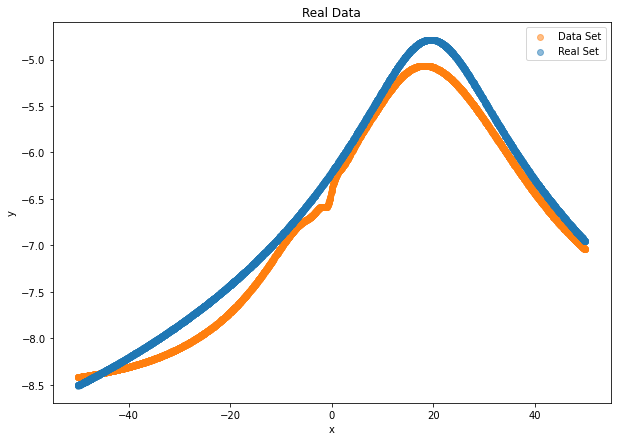

In [427]:
# Reshape the x and y data to fit them into the model
# For the henced prediction, we have to normalize the x data
x = np.array(data['x']).reshape(5000, 1)
y = np.array(data['y']).reshape(5000, 1)

# Generate the MLP regressor with the dense layers
model = MLPRegressor()
model.add(Dense(units=16, activation=Sigmoid(), input_dim=x.shape[1]))
model.add(Dense(units=32, activation=Sigmoid()))
model.add(Dense(units=16, activation=Identity()))
model.add(Dense(units=1, activation=Identity()))

# Select the loss function and perform training
loss = MSE()
model.train(loss, train_data=[x, y])

# Plot the real data and predicted result
plt.figure(figsize=(10, 7))
plt.title("Real Data")

plt.scatter(x, model.predict(x), color='tab:orange', alpha=0.5, label="Data Set")
plt.scatter(x, y, color='tab:blue', alpha=0.5, label="Real Set")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [428]:
for i in range(len(model.layers)):
    print("Weights of the layer", i, ":")
    print(model.layers[i].w, end='\n\n')

for i in range(len(model.layers)):
    print("Biases of the layer", i, ":")
    print(model.layers[i].b, end='\n\n')

Weights of the layer 0 :
[[-0.07369981  0.60322857  0.77213341 -0.18222683  0.54361548 -0.58166299
  -1.32660486  0.35009772 -0.32458945  0.06382264 -0.06254212 -0.95415478
   0.43415074  0.15534257 -0.83584527 -1.14271542]]

Weights of the layer 1 :
[[ 1.42042493e+00  1.51446403e-01  8.84888355e-01  1.40326684e-01
   1.59530418e-01 -1.11197985e+00  1.25128482e+00  1.45294022e+00
  -8.28285592e-01  7.50220164e-02 -2.28718610e+00 -3.42590616e-01
  -1.33886469e+00  4.31651658e-01  2.09804623e-01 -5.97672896e-02
   3.11306723e-02 -1.63842313e+00 -5.78704145e-01 -2.46563357e+00
   1.71160423e+00 -1.29251144e+00  7.69535154e-01 -1.23701957e+00
   1.31179198e+00  1.30679551e+00 -2.43443822e+00  9.17239809e-02
  -5.78257958e-01 -4.97664238e-01 -8.21990178e-01  1.28490407e+00]
 [-1.20775967e+00 -5.56109444e-01 -8.71718911e-01  2.69389936e-01
   3.68521307e-02 -5.18352567e-01 -5.30262357e-01 -8.62185899e-01
   1.19475316e+00 -2.21129210e+00  4.29432734e-01  2.70539368e-01
  -6.95469095e-01  3.8